Загрузка модели...
Загрузка токенизатора...
Инициализация модели DenseNet201...
Генерация описания...


c:\Python\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_1', 'input_layer_2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


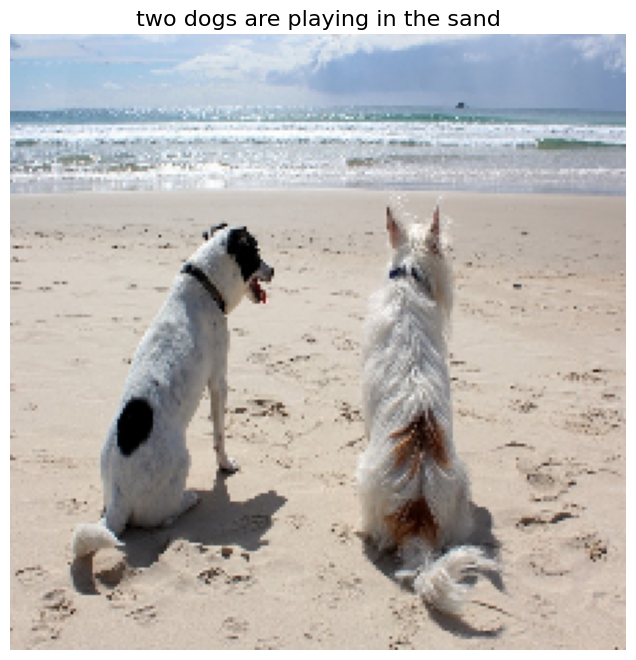

Сгенерированное описание: two dogs are playing in the sand


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

# преобразует индекс в соответствующее слово с использованием словаря токенизатора.
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# генерирует описание для изображения
def predict_caption_for_image(model, image_file, tokenizer, max_length, fe_model):
    img = load_img(image_file, target_size=(224, 224))
    img_array = img_to_array(img)  # преобразование изображения в массив

    # сохраняем оригинальное изображение для отображения
    original_img = img_array / 255.0

    # применяем нормализацию для модели
    img_array = preprocess_input(img_array)

    # извлекаем признаки (features) из изображения
    img = np.expand_dims(img_array, axis=0)  # Добавляем измерение для батча
    feature = fe_model.predict(img, verbose=0)

    # генерируем описание
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break

        in_text += " " + word

        if word == "endseq":
            break

    # убираем маркеры 'startseq' и 'endseq'
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # отображаем оригинальное изображение с подписью
    plt.figure(figsize=(8, 8))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.show()

    return caption

# основная функция
def main():
    image_file = "images/test2.jpg"
    model_path = "model.keras"
    tokenizer_path = "tokenizer.pickle"
    max_length = 34

    if not os.path.exists(image_file):
        print(f"Файл изображения {image_file} не найден.")
        return

    # загрузка модели
    print("Загрузка модели...")
    caption_model = load_model(model_path)

    # загрузка токенизатора
    print("Загрузка токенизатора...")
    with open(tokenizer_path, "rb") as file:
        tokenizer = pickle.load(file)

    # создание модели DenseNet201 для извлечения признаков
    print("Инициализация модели DenseNet201...")
    fe_model = DenseNet201(weights="imagenet", include_top=False, pooling="avg")

    # генерация описания
    print("Генерация описания...")
    caption = predict_caption_for_image(caption_model, image_file, tokenizer, max_length, fe_model)
    print(f"Сгенерированное описание: {caption}")

if __name__ == "__main__":
    main()
